# Histopathologic Cancer Detection

## Introduction
The workflow is heavily inspired by https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing.

Totally, 160,000 images that include 144,000 training images and 16,000 validation images are used to train the model. The folder structure

This is achieved by organizing a folder structure and utilizing generators to feed data to the model for training, validation, and prediction.

Note: GPU helps facilitate creating folder structures. Turn on the GPU before creating any folder structure in output directory

## 1. Import Related Library

In [1]:
from numpy.random import seed
seed(77)

import os
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## 2. Exploratory Data Analysis

In [2]:
# Define the data path
data_path = '/kaggle/input/histopathologic-cancer-detection'
input_train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
label_path = os.path.join(data_path, 'train_labels.csv')

In [3]:
os.listdir(data_path)

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

The number of train and test data points

In [4]:
print('Labeled Data Size: ',len(os.listdir(input_train_path)))
print('Test Data Size:', len(os.listdir(test_path)))

Labeled Data Size:  220025
Test Data Size: 57458


In [52]:
df_data = pd.read_csv(label_path)

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print('train_df_shape',df_data.shape)
df_data.head()

train_df_shape (220023, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Category Distribution of the data. Zero indicate no tumor tissue and one indicates having tumor tissue

In [53]:
df_data['label'].value_counts()

label
0    130907
1     89116
Name: count, dtype: int64

Text(0, 0.5, 'The num of samples')

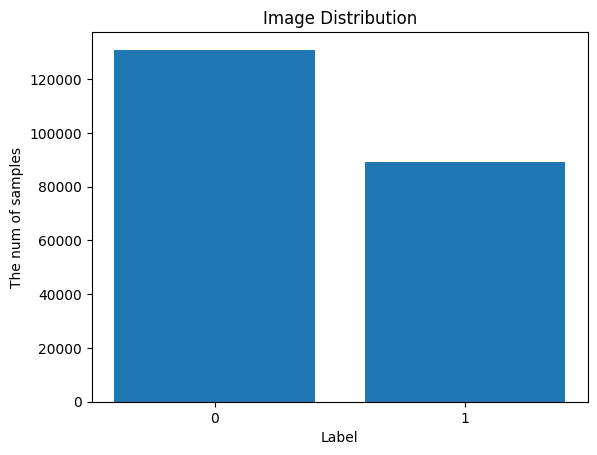

In [57]:
plt.bar([0, 1],df_data['label'].value_counts())
plt.title('Image Distribution')
plt.xticks([1,0])
plt.xlabel('Label')
plt.ylabel('The num of samples')

In [8]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """


    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols,
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=os.path.join(IMAGE_PATH, sample.iloc[j]['id'] + '.tif')
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)
    plt.tight_layout()
    plt.show()

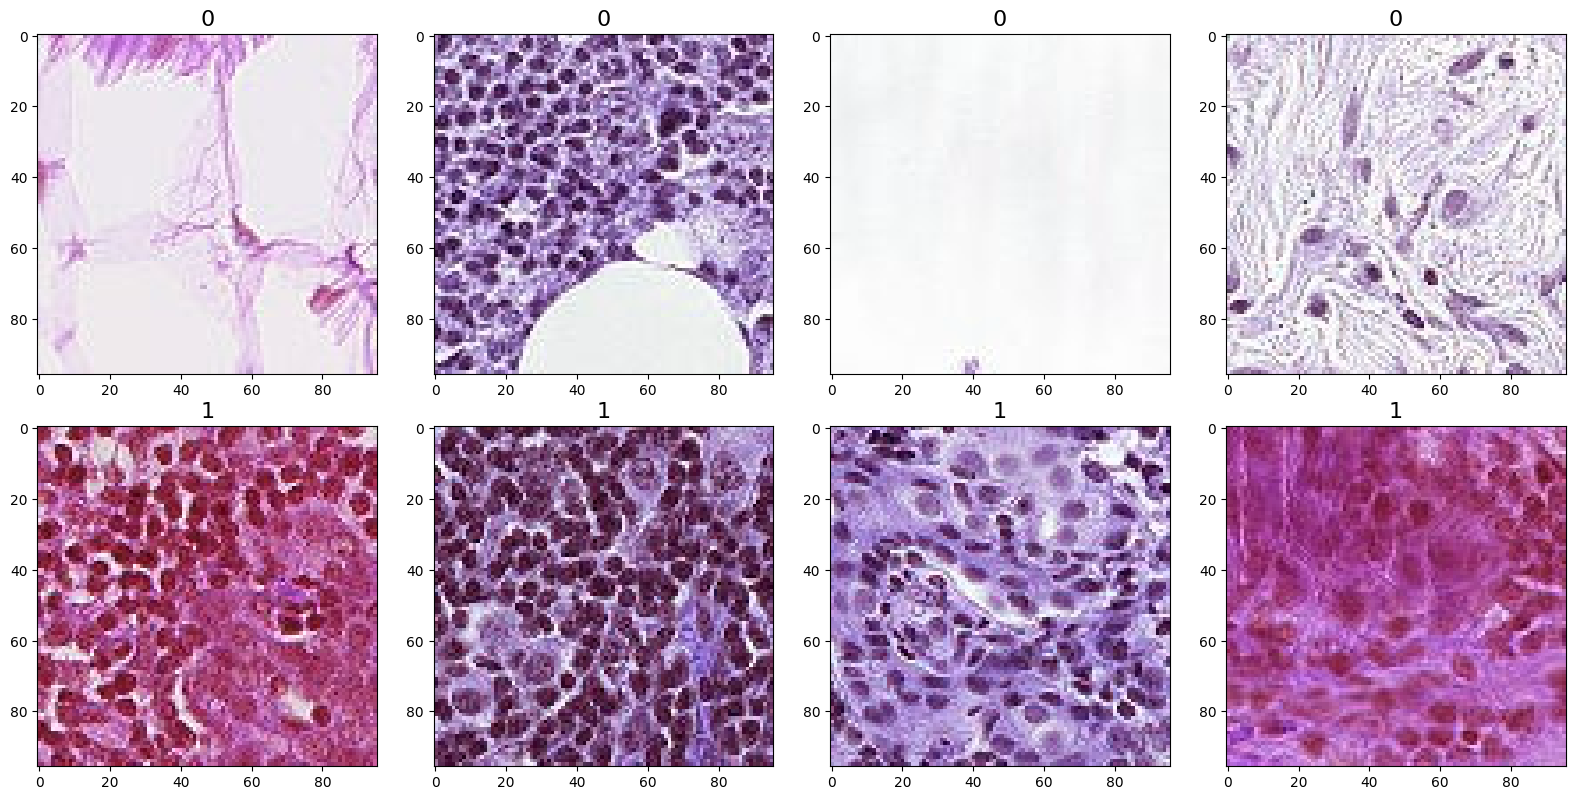

In [9]:
image_path = input_train_path
draw_category_images('label', 4, df_data, image_path)

## 3. Split Data into train and valid datasets

In [10]:
SAMPLE_SIZE = 80000 # load 80k examples for each class

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

In [11]:
print('Train Data Distribution:',df_train['label'].value_counts())
print('Validation Data Distribution:',df_val['label'].value_counts())

Train Data Distribution: label
0    72000
1    72000
Name: count, dtype: int64
Validation Data Distribution: label
0    8000
1    8000
Name: count, dtype: int64


In [12]:
df_data.head()

,id,label
33530,e78700e6c2988f83c50f5ddb56d6d128d431ffe7,0
25375,d700d91efc581057f78b592025bcc0c3cf0212bd,0
24934,e65417a5f34a8c3f9ad361342d1d43f117a2a88a,0
65625,ad2b956019f85249cecc2460e93ed1f6f662191c,0
88490,36b909f7d2daf936ed5d9c3530e9a2a81078bfda,1


In [13]:
# Set the id as the index in df_data
df_data.set_index('id', inplace = True)

## 4. Create folders for train and valid datasets

In [14]:
# Create directories
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/valid_dir'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [15]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join(input_train_path, fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join(input_train_path, fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

In [16]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/0')))
print(len(os.listdir('base_dir/train_dir/1')))

72000
72000


In [17]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/valid_dir/0')))
print(len(os.listdir('base_dir/valid_dir/1')))

8000
8000


Set up the image generator (update with tf.data)

In [18]:
IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size) 
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [19]:
print(train_steps)
print(val_steps)

4500.0
500.0


## 5. Build the model

I have referenced the following CNN architecture

https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb?scriptVersionId=7784920

Model structure (optimizer: Adam):
* In
* [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 32, 64, 128)
* Flatten
* Dense (256)
* Dropout
* Out

In each filtering block, the model structure uses three 2D convolution filtering layers. Next, the maxpool is utilized to reduce the dimensions of the feature map. At the end, it also uses dropout to reduce overfitting.

In [28]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,660,929 (6.34 MB)

 Trainable params: 1,660,929 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
model.compile(Adam(0.001), loss = "binary_crossentropy", metrics=["accuracy"])

In [30]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'0': 0, '1': 1}


## 6. Train the model

In [31]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
callbacks_list = [checkpoint, reduce_lr]

# history = model.fit(train_gen, steps_per_epoch=int(train_steps), 
#                     validation_data=val_gen,
#                     validation_steps=int(val_steps),
#                     epochs=10, verbose=1,
#                    callbacks=callbacks_list)

history = model.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 199s 42ms/step - accuracy: 0.7657 - loss: 0.4872 - val_accuracy: 0.8511 - val_loss: 0.3550 - learning_rate: 0.0010
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 184s 41ms/step - accuracy: 0.8541 - loss: 0.3449 - val_accuracy: 0.8584 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 185s 41ms/step - accuracy: 0.8679 - loss: 0.3177 - val_accuracy: 0.8964 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 185s 41ms/step - accuracy: 0.8783 - loss: 0.2953 - val_accuracy: 0.8953 - val_loss: 0.2615 - learning_rate: 0.0010
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 184s 41ms/step - accuracy: 0.8848 - loss: 0.2874 - val_accuracy: 0.9008 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 189s 42ms/step - accuracy: 0.8888 - loss: 0.2743 - val_accuracy: 0.9013 - val_loss: 0.2546 - learning_rate: 0.0010
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 187s 41ms/step -

In [32]:
# make a prediction on validation set
y_pred_keras = model.predict(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print('Area under ROC curve: ', auc_keras)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Area under ROC curve:  0.9647672734374999


#### Plot ROC Curve

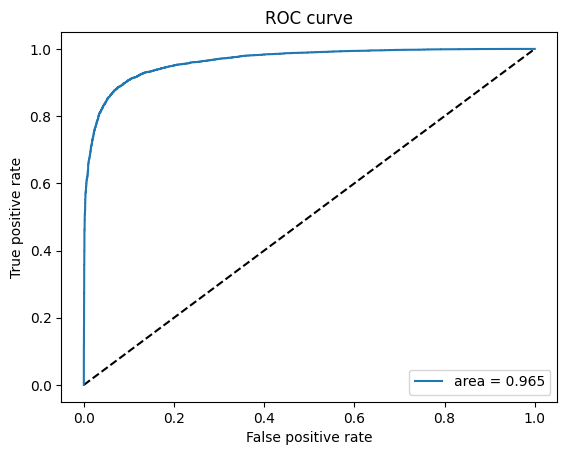

In [33]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## 7. Make a Test Prediction

In [34]:
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [35]:
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [36]:
# Transfer the test images into image_dir

test_list = os.listdir(test_path)

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join(test_path, fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [37]:
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

#### Set up the test generator

In [38]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [39]:
num_test_images = len(os.listdir('test_dir/test_images'))

# # make sure we are using the best epoch
# model.load_weights(filepath)

predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 140s 2ms/step


In [40]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['label'])
df_preds.head()

,label
0,0.995677
1,0.818912
2,0.838337
3,0.017208
4,0.043626


In [41]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.

test_filenames = test_gen.filenames
test_filenames[0:5]

['test_images/00006537328c33e284c973d7b39d340809f7271b.tif',
 'test_images/0000ec92553fda4ce39889f9226ace43cae3364e.tif',
 'test_images/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif',
 'test_images/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif',
 'test_images/000270442cc15af719583a8172c87cd2bd9c7746.tif']

In [42]:
df_preds['id'] = test_gen.filenames

def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['id'].apply(extract_id)
# df_preds = df_preds.set_index('id')
df_preds.head()

,label,id
0,0.995677,00006537328c33e284c973d7b39d340809f7271b
1,0.818912,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.838337,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.017208,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.043626,000270442cc15af719583a8172c87cd2bd9c7746


In [43]:
submission = pd.DataFrame({'id': df_preds['id'],
                          'label': df_preds['label']}).set_index('id')
submission.to_csv("submission.csv") 

In [44]:
pd.read_csv('submission.csv')

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.995677
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.818912
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.838337
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.017208
4,000270442cc15af719583a8172c87cd2bd9c7746,0.043626
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0.014074
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0.504457
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0.004523
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0.932808
